In [ ]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/demo9_data_augmentation'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
    %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/demo9_data_augmentation'
if not os.path.exists(SYM_PATH):
    !ln -s $DRIVE_PATH $SYM_PATH
    
# Change working directory
os.chdir('demo9_data_augmentation')

In [ ]:
# Install relevant packages
!pip install -r requirements.txt

In [3]:
# Loading dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from utils import run_training_loop, test_performance

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# CS 182 Demo: Data Augmentations

Time and time again, regularization has proven invaluable to machine learning practitioners. With particular focus on this class, we've discussed adapting our models to ensure they do not overfit to the training data. In other words, we want our model to generalize well to unseen data. 

Many of the approaches discussed --batch normalization, layer normalization, and dropout, to name a few-- involve tuning and adjusting the inner workings of our deep learning architectures. Although Convolutional Neural Networks (CNNs) arose out of a desire for an architecture that had invariances built into it, oftentimes in practice this isn't enough. Data augmentation, the act of modifying our input training data, provides a different approach to regularizing our models.

## Part 1: Data Augmentation in Theory

Regularization is necessary for deep learning models to generalize well to unseen data (i.e. test data), and it can be introduced into models through explicit methods such as adding a weighted $L_{1}$ or $L_{2}$ penalty, for example, to the loss function. However, regularization can also be introduced implicitly into the model through data augmentation.

Consider an edge or a pattern that consistently appears near the center of an image in a subset of the training data. For example, this might be the stripes of a tiger consistently appearing in the center, due to the images of the tiger consistently being centered on the tiger. The model (i.e. CNN) will latch onto that edge or pattern as it is designed to do. Due to translational/equivariance invariance, the model should be able to detect if the tiger and its stripes were shifted around the image, thus providing the model with information to inform its prediction (ideally, that would be 'tiger').

However, in reality, images are not always as clean-cut as the training examples in datasets such as CIFAR-10. The quality of the image could be poor (blurriness) resulting in the model poorly identifying features, or a glare in the picture that distracts the model from important patterns and edges that result in a correct classification. It might even be possible that the subset of tiger images are entirely centered on a docile tiger standing horizontally, meaning a rotated or 'active' tiger may result in a misclassification.

Thus, data augmentation during training provides a way of implicitly regularizing the model by artificially creating scenarios that could be realistically seen in the real world. These data augmentations force the model to adapt to these changes by relying less on exploiting patterns from an idealized version of images. By augmenting our data, we are approximating what our data looks like in the real world.


Data augmentation is also an avenue for domain knowledge to be exploited to help produce more accurate while still robust models. Experts and scientists can provide encodings of what is important via domain emphasis by selecting data augmentations that accurately represent what the model may encounter post-training.

## Part 2: Basic Augmentations

These augmentations are used to promote invariance to small semantically insignificant changes. A few basic augmentations are:
1. Random Cropping
2. Rescaling
3. Rotations
3. Subset
4. Color Adjustment
5. Blurring

### Using PyTorch for Data Augmentation

There are many data augmentations that are implemented in the `torchvision.transforms` modules. Below are a few examples of common data augmentations used in basic ConvNets. Let's load in a sample image of a Golden Retriever to work with.

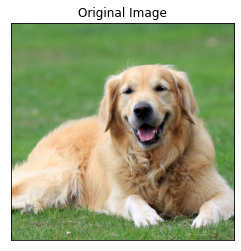

In [4]:
# Read in image as NumPy array
dog = plt.imread("images/dog.jpg")

# Convert NumPy array to Tensor
dog = torch.from_numpy(dog)

plt.imshow(dog)
plt.xticks([])
plt.yticks([])
plt.title("Original Image");

### Random Rotation
Use the `transforms.RandomRotation` method to randomly rotate an image up to a certain degree. You can find the official PyTorch documentation [here](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html).

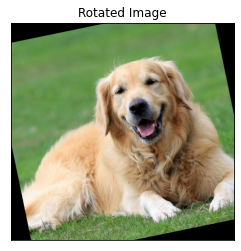

In [6]:
# Set maximum degree you'd like to rotate the image by
MAX_DEGREE = 45

# Rotate image using rotation transformation
rotation = transforms.RandomRotation(degrees=MAX_DEGREE,
                                     interpolation=transforms.functional.InterpolationMode.NEAREST,
                                     expand=False,
                                     center=None,
                                     fill=0)
dog_rotated = rotation(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_rotated);
plt.xticks([])
plt.yticks([])
plt.title("Rotated Image");

### Random Crop
Use the `transforms.RandomResizedCrop` method to crop the given image at a random location and then resize to match the original image size. Oftentimes, we fix our model architecture such that it always takes in the same size input image, thus it's important to resize after cropping. You can find the official PyTorch documentation [here](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html).

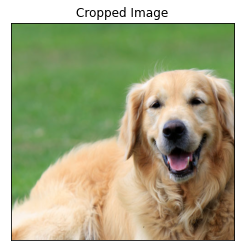

In [7]:
# Crop the input image based on crop size
crop = transforms.RandomResizedCrop(size=dog.shape[:2],
                                    scale=(0.08, 1.0),
                                    ratio=(0.75, 1.3333333333333333),
                                    interpolation=transforms.functional.InterpolationMode.BILINEAR,
                                    antialias='warn')
dog_cropped = crop(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_cropped);
plt.xticks([])
plt.yticks([]);
plt.title("Cropped Image");

Notice that the image size before and after cropping is the same:

In [8]:
print(f'Before Crop: {dog.shape}')
print(f'After Crop: {dog_cropped.shape}')

Before Crop: torch.Size([599, 615, 3])
After Crop: torch.Size([599, 615, 3])


### Gaussian Blur
Use the `transforms.GaussianBlur` method to blur the image with randomly chosen Gaussian blur. You can find the official PyTorch documentation [here](https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html).

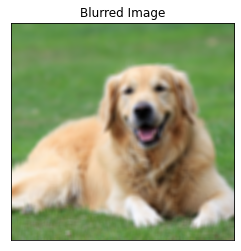

In [9]:
# Set kernel size and variance
KERNEL_SIZE=13
SIGMA_RANGE=(78,100)

# Pass a Gaussian filter over the image
blur = transforms.GaussianBlur(kernel_size=KERNEL_SIZE, sigma=SIGMA_RANGE)
dog_blurred = blur(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_blurred);
plt.xticks([])
plt.yticks([])
plt.title("Blurred Image");

<div class="alert alert-info"> <b>Try it out:</b> Play around with the <code>KERNEL_SIZE</code> and <code>SIGMA_RANGE</code> variables. How do both the kernel size and the sigma value affect the resulting blur?</div>

### Color Jitter

Use the `transforms.ColorJitter` method to randomly adjusted brightness, contrast, saturation and hue of an image. You can find the official PyTorch documentation [here](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html).

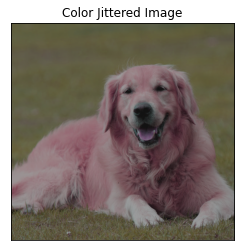

In [21]:
# Set ColorJitter parameters
BRIGHTNESS = 0.5
CONTRAST = 0.5
SATURATION = 0.5
HUE = 0.2

jitter = transforms.ColorJitter(brightness=BRIGHTNESS, contrast=CONTRAST, saturation=SATURATION, hue=HUE)
dog_jittered = jitter(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_jittered);
plt.xticks([])
plt.yticks([])
plt.title("Color Jittered Image");

### Posterize

Use the `transforms.RandomPosterize` method to posterize the image randomly with a given probability by reducing the number of bits for each color channel. You can find the official PyTorch documentation [here](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomPosterize.html).

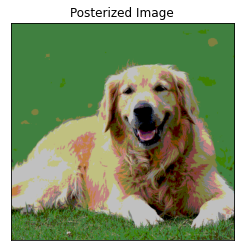

In [10]:
# Set the posterizing parameters
BITS = 2
P = 1

# Rotate image using rotation transformation
posterize = transforms.RandomPosterize(bits=BITS, p=P)
dog_posterized = posterize(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_posterized);
plt.xticks([])
plt.yticks([])
plt.title("Posterized Image");

# Part 3: Advanced Augmentations

Advanced data augmentations provide more complex and unique training examples to further regularize our model. The real world is complicated and variable, meaning unseen (by the model) data are likely to be complex and dynamic. Thus, advanced augmentations provide practitioners an ability to introduce more heavily augmented, and sometimes more realistic, data to further improve the models robustness.

### Composing Multiple Augmentations 

As machine learning practitioners, we've found that composing multiple data augmentations together, most often within a PyTorch `DataSet`, helps to improve performance and regularizes the model. Below is an example of one such composition of basic data augmentations.

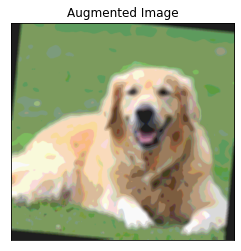

In [22]:
composed_transform = transforms.Compose([
        transforms.RandomRotation(degrees=20, 
                                  interpolation=transforms.functional.InterpolationMode.NEAREST, 
                                  expand=False, 
                                  center=None, 
                                  fill=0),
        transforms.GaussianBlur(kernel_size=13, sigma=7),
        transforms.RandomPosterize(bits=3, p=0.9),
        transforms.ColorJitter(brightness=0.3, 
                               contrast=0.3, 
                               saturation=0,
                               hue=0)
        ])
dog_augmented = composed_transform(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_augmented)
plt.xticks([])
plt.yticks([])
plt.title("Augmented Image");

### More Aggressive Data Augmentations

As shown in lecture, there are several more aggressive data augmentations that are used in practice. Empirically, they are found to have a regularizing effect on the model. Some examples are below:

<img src="https://drive.google.com/uc?id=1x_ednmeFKO-iWficKQdcMnlRaIsHiJ3r" width="800px" align="left"></img>

### PixMix

The PixMix data augmentation strategy comes from the 2022 paper [PIXMIX: Dreamlike Pictures
Comprehensively Improve Safety Measures](https://arxiv.org/pdf/2112.05135.pdf).

<img src="https://drive.google.com/uc?id=1tbz_Osm3DKIww0o7exAHKjtq2Z5zWYJa" width="800px" align="left"></img>

The following is an excerpt from the original PIXMIX paper describing the above image:
> An instance of a PIXMIX augmentation being applied to a bird image. The original clean image is mixed with augmented
versions of itself and an image such as a fractal. Bottom: Sample images from the PIXMIX mixing set. We select fractals and feature
visualizations from manually curated online sources. In ablations, we find that these new sources of visual structure for augmentations
outperform numerous synthetic image distributions explored in prior work."

The aforementioned paper shows empirical evidence that more aggressive data augmentations can lead to higher performance on unseen data.

## Part 4: Augmentations in Practice

### Loading the Model Architecture

To show the empirical effects of data augmentations in practice, we'll utilize the ResNet-18 architecture with untrained weights. The original [ResNet](https://arxiv.org/abs/1512.03385) architecture allowed for much deeper models due to its innovative approach towards solving the "vanishing gradient" problem: the skip connection. ResNet has proven to be one of the most successful architectures used for object classification and recognition. You can examine the specific layers and parameters below.

In [12]:
model = torchvision.models.resnet18(weights=None)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We will use the same ResNet-18 architecture to train two models: a base model with no data augmentation, and another model trained with data augmentation. Below, we use methods from the `torchvision.transforms` module to compose a set of transformations that we can apply to the training data. We augment the data by performing one random horizontal flip followed by one random crop. The PyTorch code is shown below:

```python
data_aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

base_transform = transforms.Compose([
    transforms.ToTensor(),
])
```

For the sake of time and computation, we have ommitted the training process, and instead have loaded in the trained models below. To reproduce the process and model training, please reference the `model_train.py` and `utils.py` files located at the root of the directory.

In [13]:
# Load trained models from models folder
base_model = torch.load("models/resnet18_base.pt")
aug_model = torch.load("models/resnet18_data_augment.pt")

Let's take a look at the training and validation loss curves for each model:

<img src="https://drive.google.com/uc?id=1oHsuSsSX4mBXFSHqmpYV7LWu-wIfTIco" width="800px" align="left"></img>
<img src="https://drive.google.com/uc?id=1el9SeHIfo0KVMGEynMkIih9qnAbk_yvO" width="800px" align="left"></img>

<div class="alert alert-info"> <b>What do you notice?</b> Consider the trends of the train and validation curves in respect to each other.</div>

Now, let's examine how each model performs on the test dataset. First, we must load in the test dataset:

In [15]:
cifar10_test = torchvision.datasets.CIFAR10(root = "data", train=False, download = True, transform=transforms.ToTensor())

Files already downloaded and verified


Run the following cells to test the performances of both the base model and data augmented model. You'll see that the model trained using the data augmentations performs better than the base model on unseen test data. You can find the `test_performance` function in the `utils.py` file.

In [16]:
# This may take up to a minute to run
test_performance(base_model, test_data=cifar10_test)

Test set: Average loss: 0.0402, Accuracy: 7185/10000 (71.8500)


(0.0402332171946764, 0.7185)

In [17]:
# This may take up to a minute to run
test_performance(aug_model, test_data=cifar10_test)

Test set: Average loss: 0.0249, Accuracy: 7391/10000 (73.9100)


(0.02491027995646, 0.7391)

Although the base model's training loss was nearly half that of the data augmented model's training loss, the base model's performance on the validation set and test set was poor. On the other hand, the data augmented model's performance and accuracy on the test set was better than the base model. This example displays the regularization effect data augmentation has on model training.